In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

from utils.functions import reduce_sector_cardinality

### Working on quarterly data

In [12]:
merged_data_quarterly = pd.read_feather("./data/merged_data_quarterly.feather")

#### Creation of the target: 1year price, shifting the price column 4 quarters

In [15]:
merged_data_quarterly['1year_price'] = merged_data_quarterly.groupby('asset_num')['price'].shift(-4)

There are few assets, excepting the last 4 quarters where obviously we don't have the target, that have null price.

In [16]:
merged_data_quarterly.head()

,quarter,asset_num,price,cap_ex,cash,dil_shares,ebit,ebitda,net_inc,survivor,T_assets,T_debt,T_rev,sector,1year_price
0,2005Q1,12861,1.256760,-190.000,2475.000,22880.814320,678.000,825.300,508.000,True,9362.000,0.000,9763.000,"Technology Hardware, Storage & Peripherals",1.891625
1,2005Q1,12883,15.538408,-2.231,58.367,90.187000,259.082,260.558,281.445,False,3491.427,1578.374,336.082,Asset Management & Custody Banks,18.949231
2,2005Q1,12911,33.585000,-60.294,336.525,488.400994,599.244,661.568,479.257,True,2122.810,0.000,1716.182,Application Software,34.950000
3,2005Q1,12913,13.929720,-12.000,88.400,810.770999,35.500,81.200,71.300,True,1432.900,400.000,891.000,Technology Hardware & Equipment,25.590000
4,2005Q1,12924,29.760000,-40.835,517.654,228.000000,261.573,313.522,221.508,True,1142.204,0.000,1233.767,Application Software,38.520000


In [17]:
merged_data_quarterly['1year_price']

0         1.891625
1        18.949231
2        34.950000
3        25.590000
4        38.520000
           ...    
74097          NaN
74098          NaN
74099          NaN
74100          NaN
74101          NaN
Name: 1year_price, Length: 74102, dtype: float64

In [18]:
merged_data_quarterly.head()

,quarter,asset_num,price,cap_ex,cash,dil_shares,ebit,ebitda,net_inc,survivor,T_assets,T_debt,T_rev,sector,1year_price
0,2005Q1,12861,1.256760,-190.000,2475.000,22880.814320,678.000,825.300,508.000,True,9362.000,0.000,9763.000,"Technology Hardware, Storage & Peripherals",1.891625
1,2005Q1,12883,15.538408,-2.231,58.367,90.187000,259.082,260.558,281.445,False,3491.427,1578.374,336.082,Asset Management & Custody Banks,18.949231
2,2005Q1,12911,33.585000,-60.294,336.525,488.400994,599.244,661.568,479.257,True,2122.810,0.000,1716.182,Application Software,34.950000
3,2005Q1,12913,13.929720,-12.000,88.400,810.770999,35.500,81.200,71.300,True,1432.900,400.000,891.000,Technology Hardware & Equipment,25.590000
4,2005Q1,12924,29.760000,-40.835,517.654,228.000000,261.573,313.522,221.508,True,1142.204,0.000,1233.767,Application Software,38.520000


In [19]:
merged_data_quarterly.isna().sum()

quarter            0
asset_num          0
price          18203
cap_ex         20736
cash           17199
dil_shares     17096
ebit           20322
ebitda         20592
net_inc        17082
survivor           0
T_assets       17078
T_debt         17082
T_rev          17087
sector             0
1year_price    21288
dtype: int64

#### Creating survivor dataset in order to get only the assets that were on the SP500

In [20]:
df_survivor = merged_data_quarterly[merged_data_quarterly['survivor']==1].reset_index(drop=True)
df_survivor.head()

,quarter,asset_num,price,cap_ex,cash,dil_shares,ebit,ebitda,net_inc,survivor,T_assets,T_debt,T_rev,sector,1year_price
0,2005Q1,12861,1.256760,-190.000,2475.000,22880.814320,678.000,825.300,508.000,True,9362.000,0.0,9763.000,"Technology Hardware, Storage & Peripherals",1.891625
1,2005Q1,12911,33.585000,-60.294,336.525,488.400994,599.244,661.568,479.257,True,2122.810,0.0,1716.182,Application Software,34.950000
2,2005Q1,12913,13.929720,-12.000,88.400,810.770999,35.500,81.200,71.300,True,1432.900,400.0,891.000,Technology Hardware & Equipment,25.590000
3,2005Q1,12924,29.760000,-40.835,517.654,228.000000,261.573,313.522,221.508,True,1142.204,0.0,1233.767,Application Software,38.520000
4,2005Q1,12995,17.846608,-24.693,579.936,372.299000,314.926,345.405,275.111,True,1746.666,0.0,1016.364,Semiconductors,18.622548


In [21]:
df_survivor.isna().sum()

quarter           0
asset_num         0
price            26
cap_ex         2750
cash            461
dil_shares      318
ebit           2943
ebitda         3007
net_inc         417
survivor          0
T_assets        426
T_debt          428
T_rev           417
sector            0
1year_price    2692
dtype: int64

In [22]:
df_survivor[df_survivor['price'].isna()]['asset_num'].value_counts().reset_index()

,asset_num,count
0,741543,14
1,64740,10
2,94833,2


After analyzing these 3 assets, we can see a strange pattern in them and the data is not reliable. We will remove them from the dataset.

In [23]:
na_assets = df_survivor[df_survivor['price'].isna()]['asset_num'].unique()
na_assets

array([ 64740,  94833, 741543])

In [24]:
df_survivor = df_survivor[~df_survivor['asset_num'].isin(na_assets)]

In [25]:
### Number of assets before transformations
merged_data_quarterly['asset_num'].nunique()

938

In [26]:
### Number of assets after transformations
df_survivor['asset_num'].nunique()

912

In [27]:
assets_x_quarter = df_survivor.groupby('quarter')['asset_num'].nunique().reset_index()['asset_num'].value_counts().reset_index()
assets_x_quarter

,asset_num,count
0,498,36
1,500,20
2,499,13
3,497,7
4,496,3


### Reducing the cardinality of sector column

In [28]:
df_survivor = reduce_sector_cardinality(df_survivor)

In [29]:
df_survivor['new_sector'].value_counts()

new_sector
Financials                5821
Industrials               5305
Consumer Discretionary    4854
Information Technology    4663
Health Care               4612
Consumer Staples          3087
Energy                    2664
Utilities                 2373
Materials                 2259
Communication Services    1901
Real Estate               1843
Name: count, dtype: int64

In [30]:
# Percentage of missing values per column by quarter
df_survivor.groupby('quarter').apply(
    lambda group: group.isnull().mean(),include_groups=False)

,asset_num,price,cap_ex,cash,dil_shares,ebit,ebitda,net_inc,survivor,T_assets,T_debt,T_rev,sector,1year_price,new_sector
quarter,,,,,,,,,,,,,,,
2005Q1,0.0,0.0,0.080321,0.030120,0.020080,0.104418,0.106426,0.018072,0.0,0.030120,0.030120,0.018072,0.0,0.024096,0.0
2005Q2,0.0,0.0,0.058233,0.018072,0.020080,0.106426,0.110442,0.018072,0.0,0.018072,0.018072,0.018072,0.0,0.038153,0.0
2005Q3,0.0,0.0,0.060120,0.020040,0.020040,0.104208,0.106212,0.016032,0.0,0.018036,0.018036,0.016032,0.0,0.034068,0.0
2005Q4,0.0,0.0,0.060120,0.020040,0.018036,0.104208,0.108216,0.020040,0.0,0.020040,0.020040,0.020040,0.0,0.030060,0.0
2006Q1,0.0,0.0,0.066132,0.018036,0.018036,0.100200,0.102204,0.018036,0.0,0.018036,0.018036,0.018036,0.0,0.036072,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q3,0.0,0.0,0.070281,0.006024,0.000000,0.060241,0.064257,0.006024,0.0,0.006024,0.006024,0.006024,0.0,0.004016,0.0
2023Q4,0.0,0.0,0.068273,0.000000,0.000000,0.054217,0.058233,0.000000,0.0,0.000000,0.002008,0.000000,0.0,1.000000,0.0
2024Q1,0.0,0.0,0.070281,0.002008,0.000000,0.056225,0.058233,0.002008,0.0,0.002008,0.002008,0.002008,0.0,1.000000,0.0


After analyzing the % of missing values by quarter, we can see that there is no alarming situation, at most there is a 10% of missing values in some variables.

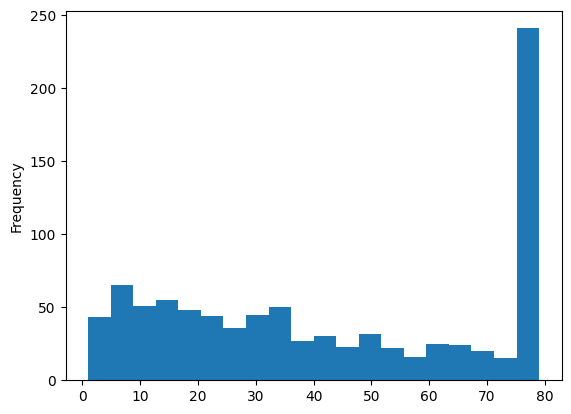

In [31]:
df_survivor.groupby('asset_num').count().sort_values('quarter',ascending=False)['quarter'].plot(kind='hist',bins=20)
plt.show()

### Feature Engineering

#### Creating the following features:
**Ratios of features:**

EBIT Margin: EBIT / Total Revenues

EBITDA Margin: EBITDA / Total Revenues

Net Margin: Net Income / Total Revenues

Return on Assets (ROA): Net Income / Total Assets

Return on Equity (ROE): Net Income / (Total Assets - Total Debt)

Debts on Assets: Total Debt / Total Assets

Net Debt: Total Debt - Cash And Equivalent

Cash ratio: Cash And Equivalent / Total Debt

Price earning ratio : Prices / Net income per share

Enterprise value (EV): Market cap(Prices x Shares) + Total Debt - Cash and equivalents


In [32]:
df_final = df_survivor.copy()

In [35]:
df_final['ebit_marg'] = df_final['ebit'] / df_final['T_rev']
df_final['ebitda_marg'] = df_final['ebitda'] / df_final['T_rev']
df_final['net_marg'] = df_final['net_inc'] / df_final['T_rev']
df_final['ROA'] = df_final['net_inc'] / df_final['T_assets']
df_final['ROE'] = df_final['net_inc'] / (df_final['T_assets'] - df_final['T_debt'])
df_final['debts_assets'] = df_final['T_debt'] / df_final['T_assets']
df_final['net_debt'] = df_final['T_debt'] - df_final['cash']
df_final['cash_ratio'] = df_final['cash'] / df_final['T_debt']
df_final['net_income_per_share'] = df_final['net_inc'] / df_final['dil_shares']
df_final['price_earning_ratio'] = df_final['price'] / df_final['net_income_per_share']
df_final['ev'] = df_final['price'] * df_final['dil_shares'] + df_final['T_debt'] - df_final['cash']

df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [37]:
#Filtering the data excluding the last 4 quarters to see the amount of missing values. 
exclude_periods = [
    pd.Period('2023Q4', freq='Q-DEC'),
    pd.Period('2024Q1', freq='Q-DEC'),
    pd.Period('2024Q2', freq='Q-DEC'),
    pd.Period('2024Q3', freq='Q-DEC'),
]

excluded_data = df_final[~df_final['quarter'].isin(exclude_periods)]
excluded_data.isna().sum()

quarter                    0
asset_num                  0
price                      0
cap_ex                  2597
cash                     445
dil_shares               304
ebit                    2821
ebitda                  2876
net_inc                  401
survivor                   0
T_assets                 410
T_debt                   410
T_rev                    401
sector                     0
1year_price              670
new_sector                 0
ebit_marg               2821
ebitda_marg             2876
net_marg                 401
ROA                      419
ROE                      419
debts_assets             410
net_debt                 445
cash_ratio              1711
net_income_per_share     598
price_earning_ratio      599
ev                       645
dtype: int64

Missing values in the target are caused by two main reasons:
- Missing values in the target column are due to the fact that when a company is no longer in the SP500, usually we stop having information about it, so we can't have a target for the last 4 quarters.
- The other missing values we have at the target column appear at the last 4 quarters due to the fact that we can't have the target for them.

We will remove the rows with missing values in the target column.

In [38]:
df_final.dropna(subset=['1year_price'], inplace=True)

In [39]:
df_final.isna().sum()

quarter                    0
asset_num                  0
price                      0
cap_ex                  2561
cash                     431
dil_shares               284
ebit                    2741
ebitda                  2796
net_inc                  387
survivor                   0
T_assets                 396
T_debt                   396
T_rev                    387
sector                     0
1year_price                0
new_sector                 0
ebit_marg               2741
ebitda_marg             2796
net_marg                 387
ROA                      405
ROE                      405
debts_assets             396
net_debt                 431
cash_ratio              1673
net_income_per_share     564
price_earning_ratio      565
ev                       611
dtype: int64

In [40]:
df_final['quarter'].value_counts().value_counts()

count
492    10
493     9
494     8
490     8
491     7
484     5
479     4
482     4
486     4
496     3
495     3
489     2
481     2
498     1
485     1
487     1
488     1
497     1
478     1
Name: count, dtype: int64

In [42]:
df_final.to_feather("./data/final_data.feather")